In [36]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
import PIL
import os
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization

# Local imports
import sys
sys.path.append('../../../')
import stlstuff as sls
import imagestuff as ims
import statstuff as sts

In [37]:
%matplotlib notebook

In [38]:
# Graphics parameters
fontsize = 10
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

In [39]:
# Specify the files we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentroot1='Segments2'
Segmentroot2='Segments3'

/Users/nesh/Documents/repositories/ice4/crystals/2018-07-05 /Case1.0 (calibration)
2018-07-05 /Case1.0 (calibration)


In [40]:
# Derivative names
Compressedfilename1 = Segmentroot1+'retrieved.npz'; print (Compressedfilename1)
Compressedfilename2 = Segmentroot2+'retrieved.npz'; print (Compressedfilename2)

Segments2retrieved.npz
Segments3retrieved.npz


In [41]:
# Get the retrieved surface
npzfile1 = np.load(Compressedfilename1)
imageroot1 = np.array_str(npzfile1['imageroot'])
dx,dy,cA,cB,cC,cD,Filename1 = ims.getc2('', 'SEMimages/', imageroot1)
print("dx and dy", dx, dy)

npzfile2 = np.load(Compressedfilename2)
imageroot2 = np.array_str(npzfile2['imageroot'])
dx,dy,cA,cB,cC,cD,Filename2 = ims.getc2('', 'SEMimages/', imageroot2)
print("dx and dy", dx, dy)

dx and dy 0.4409722 0.4409722
dx and dy 0.4409722 0.4409722


In [42]:
# Extracting from the stored files
nx1list1 = npzfile1['nx1list']
nx2list1 = npzfile1['nx2list']
ny1list1 = npzfile1['ny1list']
ny2list1 = npzfile1['ny2list']
pA1 = npzfile1['pA']
pB1 = npzfile1['pB']
pC1 = npzfile1['pC']
pD1 = npzfile1['pD']
sA1 = npzfile1['sA']
sB1 = npzfile1['sB']
sC1 = npzfile1['sC']
sD1 = npzfile1['sD']
nxi1 = npzfile1['nxi']
nyi1 = npzfile1['nyi']
dnx1 = npzfile1['dnx']
dny1 = npzfile1['dny']
solution1 = npzfile1['solution']
nsegments1 = len(nx1list1); print(nsegments1)
    
nx1list2 = npzfile2['nx1list']
nx2list2 = npzfile2['nx2list']
ny1list2 = npzfile2['ny1list']
ny2list2 = npzfile2['ny2list']
pA2 = npzfile2['pA']
pB2 = npzfile2['pB']
pC2 = npzfile2['pC']
pD2 = npzfile2['pD']
sA2 = npzfile2['sA']
sB2 = npzfile2['sB']
sC2 = npzfile2['sC']
sD2 = npzfile2['sD']
nxi2 = npzfile2['nxi']
nyi2 = npzfile2['nyi']
dnx2 = npzfile2['dnx']
dny2 = npzfile2['dny']
solution2 = npzfile2['solution']
nsegments2 = len(nx1list2); print(nsegments2)

4
1


In [43]:
# Creating smaller arrays with just the retrieved panels
nxtot = nx2list1[-1]-nx1list1[0]; #print(nxtot)
nytot = ny2list1[-1]-ny1list1[0]; #print(nytot)
solution1_panels = np.flipud(solution1[nx1list1[0]:nx2list1[-1],ny1list1[0]:ny2list1[-1]])
solution2_panels = np.flipud(solution2[nx1list1[0]:nx2list1[-1],ny1list1[0]:ny2list1[-1]])

# Correcting levels
for isegment in range(nsegments1):
    ix1 = nx1list1[isegment]-nx1list1[0]; #print(ix1)
    ix2 = nx2list1[isegment]-nx1list1[0]; #print(ix2)
    iy1 = ny1list1[isegment]-ny1list1[0]; #print(iy1)
    iy2 = ny2list1[isegment]-ny1list1[0]; #print(iy2)
    mean_panel1 = np.mean(solution1_panels[ix1:ix2,iy1:iy2])
    mean_panel2 = np.mean(solution2_panels[ix1:ix2,iy1:iy2])
    solution1_panels[ix1:ix2,iy1:iy2] += mean_panel2-mean_panel1
    print(ix1,ix2,iy1,iy2,mean_panel2-mean_panel1)

solution_panels_diff = solution1_panels-solution2_panels



# meandiff = np.mean(solution1_panels-solution2_panels); print('mean diff = ', meandiff)
# solution1_panels -= meandiff
# solution_panels_diff = solution1_panels-solution2_panels

# solution1_panels = np.zeros((nxtot,nytot)); print(np.shape(solution1_panels))
# solution2_panels = np.zeros((nxtot,nytot)); print(np.shape(solution2_panels))
# for isegment in range(nsegments1):
#     print()
    
#     np.mean(solution1_panels-solution2_panels); print('mean diff = ', meandiff)


0 30 0 30 1.7808656333363337
0 30 30 60 1.8469868635180293
30 60 0 30 1.838523900533885
30 60 30 60 1.9280606310099155


<IPython.core.display.Javascript object>


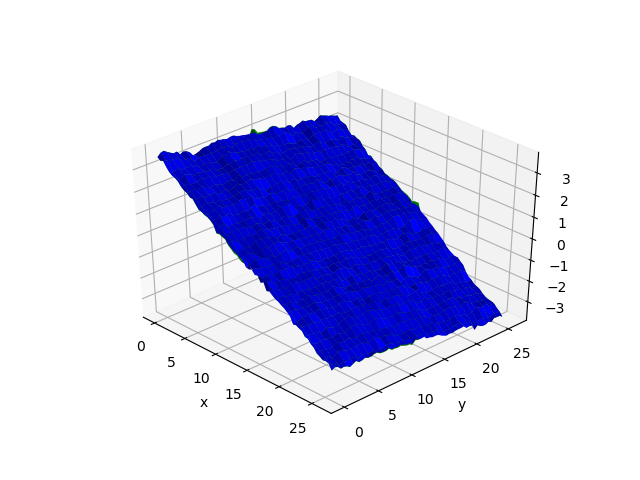

<IPython.core.display.Javascript object>


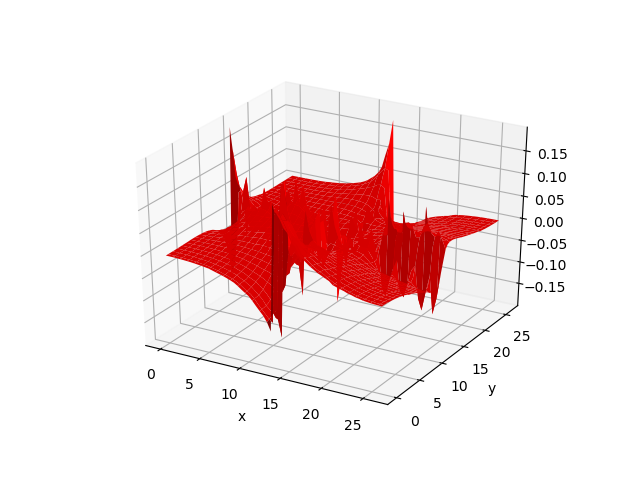

<IPython.core.display.Javascript object>


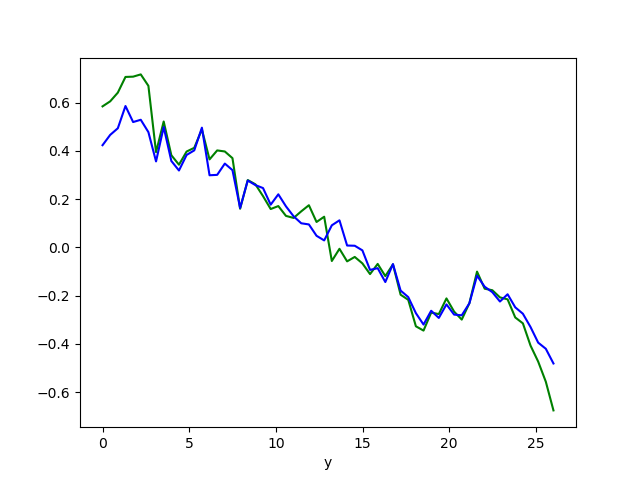

<IPython.core.display.Javascript object>


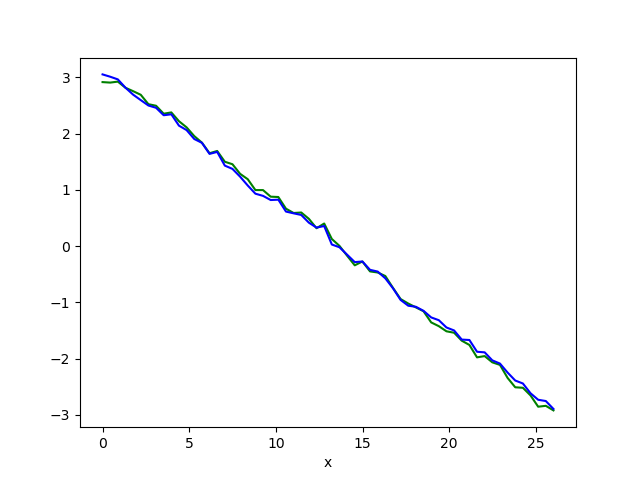

error =  0.031071062227044654


In [44]:
xmaxtot = (nxtot-1)*dx; #print (xmaxtot)
ymaxtot = (nytot-1)*dy; #print (ymaxtot)
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_ytot,surf_xtot); #print(np.shape(surf_xgridtot))
surf_ygridtot = np.flipud(surf_ygridtot)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot,surf_ygridtot,solution1_panels, color='g')
ax.plot_surface(surf_xgridtot,surf_ygridtot,solution2_panels, color='b')
ax.set_xlabel('x')
ax.set_ylabel('y')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot,surf_ygridtot,solution_panels_diff, color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.figure()
midpt = int(nxtot/2)
plt.plot(surf_ygridtot[:,midpt],solution1_panels[:,midpt], color='g')
plt.plot(surf_ygridtot[:,midpt],solution2_panels[:,midpt], color='b')
plt.xlabel('y')

plt.figure()
midpt = int(nytot/2)
plt.plot(surf_xgridtot[midpt,:],solution1_panels[midpt,:], color='g')
plt.plot(surf_xgridtot[midpt,:],solution2_panels[midpt,:], color='b')
plt.xlabel('x')

print('error = ', np.std(solution_panels_diff))